## Import Library


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

## Read Dataset 

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv.test
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv.test
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__pycache__/__init__.cpython-37.pyc


In [3]:
train_df = pd.read_csv(
    '/kaggle/input/riiid-test-answer-prediction/train.csv', 
    low_memory=False, 
    nrows=10**6, 
    dtype={
        'row_id': 'int64', 
        'timestamp': 'int64', 
        'user_id': 'int32', 
        'content_id': 'int16', 
        'content_type_id': 'int8',
        'task_container_id': 'int16', 
        'user_answer': 'int8', 
        'answered_correctly': 'int8', 
        'prior_question_elapsed_time': 'float32', 
        'prior_question_had_explanation': 'boolean'
    }
)

In [4]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


## Featureset Description

- row_id: (int64) ID code for the row.

- timestamp: (int64) the time between this user interaction and the first event from that user.

- user_id: (int32) ID code for the user.

- content_id: (int16) ID code for the user interaction

- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

- prior_question_elapsed_time: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

## Data Analysis 

In [5]:
# Find the number of unique users 
len(train_df['user_id'].unique())

3824

In [6]:
# group the training dataset by userid 
grouped_by_user_df = train_df.groupby('user_id')

In [7]:
# find number of interactions per user
grouped_by_user_df['user_id'].count()


user_id
115          46
124          30
2746         20
5382        128
8623        112
           ... 
20913319    416
20913864     21
20938253    535
20948951     51
20949024     48
Name: user_id, Length: 3824, dtype: int64

array([[<AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

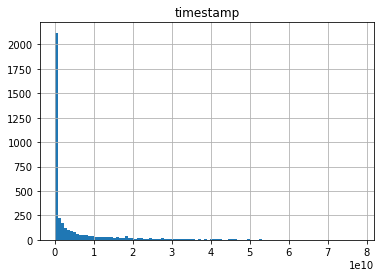

In [8]:
# distribution of timestamp
grouped_by_user_df.agg({'timestamp': 'max'}).hist(bins = 100)

In [9]:
# discard lectures 
train_questions_only_df = train_df[train_df['answered_correctly']!=-1]

In [10]:
# group by userid 
grouped_by_user_df = train_questions_only_df.groupby('user_id')

In [11]:
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count'] })

In [12]:
user_answers_df

answered_correctly      
                       mean count
user_id                          
115                0.695652    46
124                0.233333    30
2746               0.578947    19
5382               0.672000   125
8623               0.642202   109
...                     ...   ...
20913319           0.630653   398
20913864           0.333333    21
20938253           0.608779   524
20948951           0.607843    51
20949024           0.312500    48

[3824 rows x 2 columns]

<AxesSubplot:>

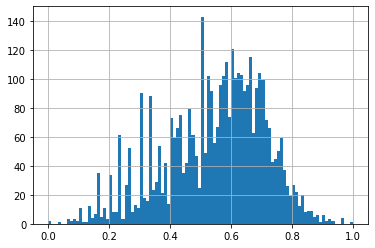

In [13]:
user_answers_df[('answered_correctly','mean')].hist(bins = 100)

<AxesSubplot:>

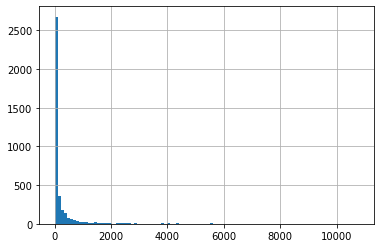

In [14]:
user_answers_df[('answered_correctly','count')].hist(bins = 100)

In [15]:
(user_answers_df[('answered_correctly','count')]< 50).mean()

0.5360878661087866

<AxesSubplot:>

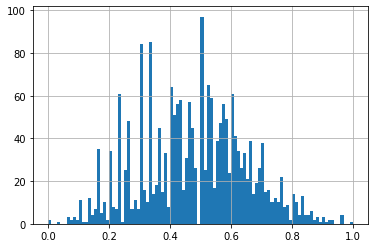

In [16]:
user_answers_df[user_answers_df[('answered_correctly','count')]< 50][('answered_correctly','mean')].hist(bins=100)

<AxesSubplot:>

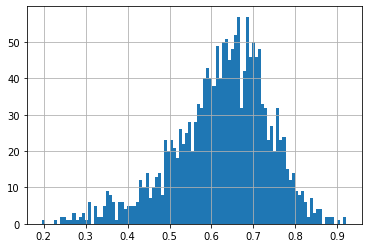

In [17]:
user_answers_df[user_answers_df[('answered_correctly','count')]> 50][('answered_correctly','mean')].hist(bins=100)

In [18]:
user_answers_df[user_answers_df[('answered_correctly','count')]> 50][('answered_correctly','mean')].mean()

0.6241490112253408

<AxesSubplot:>

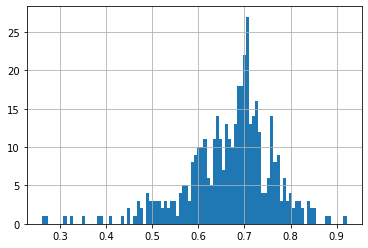

In [19]:
user_answers_df[user_answers_df[('answered_correctly','count')] >= 500][('answered_correctly','mean')].hist(bins = 100)

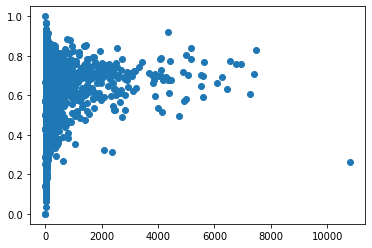

In [20]:
plt.scatter(x = user_answers_df[('answered_correctly','count')], y=user_answers_df[ ('answered_correctly','mean')])

In [21]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')

In [22]:
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count'] })

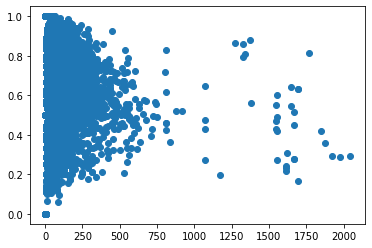

In [25]:
plt.scatter(x = content_answers_df[('answered_correctly','count')], y=content_answers_df[ ('answered_correctly','mean')])

<AxesSubplot:>

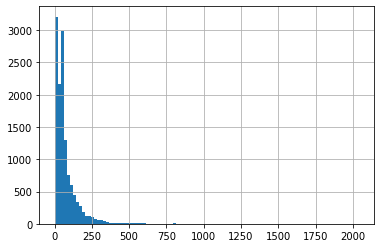

In [26]:
content_answers_df[('answered_correctly','count')].hist(bins=100)

<AxesSubplot:>

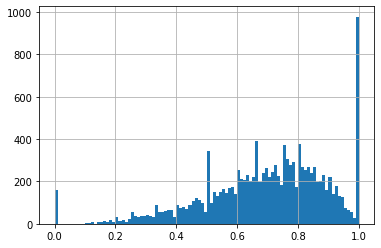

In [27]:
content_answers_df[('answered_correctly','mean')].hist(bins=100)

<AxesSubplot:>

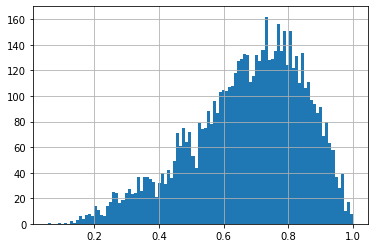

In [28]:
content_answers_df[content_answers_df[('answered_correctly','count')]>50][('answered_correctly','mean')].hist(bins = 100)

In [29]:
features_part_df = train_df.iloc[:int(9 /10 * len(train_df))]

In [30]:
features_part_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [31]:
train_part_df = train_df.iloc[int(9 /10 * len(train_df)):]

In [32]:
train_questions_only_df = features_part_df[features_part_df['answered_correctly']!=-1]

In [33]:
grouped_by_user_df = train_questions_only_df.groupby('user_id')

In [34]:
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count']}).copy()

In [35]:
user_answers_df.columns = ['mean_user_accuracy', 'questions_answered']

In [36]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')

In [37]:
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count'] }).copy()
content_answers_df.columns = ['mean_accuracy', 'question_asked']

In [38]:
del train_df
del features_part_df
del grouped_by_user_df
del grouped_by_content_df

In [39]:
import gc

In [40]:
gc.collect()

240

In [41]:
features = ['timestamp','mean_user_accuracy', 'questions_answered','mean_accuracy', 'question_asked', 'prior_question_elapsed_time', 'prior_question_had_explanation']

In [42]:
target = 'answered_correctly'

In [43]:
train_part_df = train_part_df[train_part_df[target] != -1]

In [44]:
train_part_df = train_part_df.merge(user_answers_df, how = 'left', on = 'user_id')

In [45]:
train_part_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'mean_user_accuracy', 'questions_answered'],
      dtype='object')

In [46]:
train_part_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_user_accuracy,questions_answered
0,900000,23452298654,18789336,8144,0,955,0,0,4250.0,True,0.309689,2312.0
1,900001,23452298654,18789336,8146,0,955,3,0,4250.0,True,0.309689,2312.0
2,900002,23452320119,18789336,10166,0,956,3,0,2000.0,True,0.309689,2312.0
3,900003,23452320119,18789336,10165,0,956,3,0,2000.0,True,0.309689,2312.0
4,900004,23452320119,18789336,10167,0,956,1,1,2000.0,True,0.309689,2312.0


In [47]:
train_part_df = train_part_df.merge(content_answers_df, how = 'left', on = 'content_id')

In [48]:
train_part_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'mean_user_accuracy', 'questions_answered', 'mean_accuracy',
       'question_asked'],
      dtype='object')

In [49]:
train_part_df['prior_question_had_explanation'] = train_part_df['prior_question_had_explanation'].fillna(value = False).astype(bool)

In [50]:
train_part_df.fillna(value = -1, inplace = True)

In [51]:
train_part_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'mean_user_accuracy', 'questions_answered', 'mean_accuracy',
       'question_asked'],
      dtype='object')

In [52]:
train_part_df = train_part_df[features + [target]]

In [53]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [54]:
lgbm = LGBMClassifier(
    boosting_type='rf', 
    num_leaves=31, 
    max_depth=- 1, 
    n_estimators=50, 
    min_child_samples=1000, 
    subsample=0.7, 
    subsample_freq=1, 
    n_jobs= 2
)

In [55]:
lgbm.fit(train_part_df[features], train_part_df[target])

LGBMClassifier(boosting_type='rf', min_child_samples=1000, n_estimators=50,
               n_jobs=2, subsample=0.7, subsample_freq=1)

In [56]:
roc_auc_score(train_part_df[target].values, lgbm.predict_proba(train_part_df[features])[:,1])

0.7164110771388731

In [57]:
import riiideducation

In [58]:
env = riiideducation.make_env()

In [59]:
iter_test = env.iter_test()

In [61]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_answers_df, how = 'left', on = 'user_id')
    test_df = test_df.merge(content_answers_df, how = 'left', on = 'content_id')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df.fillna(value = -1, inplace = True)

    test_df['answered_correctly'] = lgbm.predict_proba(test_df[features])[:,1]
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])